# PCB Thermography Analysis Program
### Objective
This program is designed to process PCB thermography images (both radiometric `.tif` and non-radiometric `.jpg`/`.png` formats). The workflow involves:
1. Loading and displaying the thermography image.
2. Selecting and centering the PCB by defining the corners.
3. Defining an emissivity matrix for the PCB.
4. Calibrating the image based on emissivity and temperature data.

The program adapts to both `.tif` (radiometric) images and non-radiometric RGB images (`.jpg`, `.png`).

---


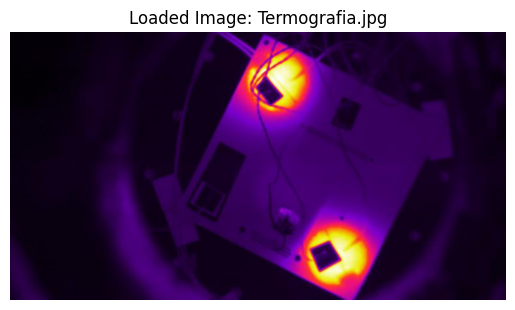

Image Termografia.jpg loaded and displayed successfully.


In [1]:
# Import necessary modules for automatic reloading of modified modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Import custom image processing functions
from image_processing import load_and_display_image, select_corners_jpg, select_corners_tif
import emissivity_processing as ep
import calibration_processing as cp

# Ask the user to input the image file name (with extension)
image_name = input("Please enter the image name with extension (e.g., image.jpg or image.tif): ")

#image_name = "Thermography.tif"

#image_name = "Termografia.jpg"

# Load and display the image
image = load_and_display_image(image_name)

# Check if the image was loaded successfully
if image is not None:
    print(f"Image {image_name} loaded and displayed successfully.")
else:
    print(f"Failed to load the image {image_name}.")


## Processing the image

Select 4 corners of the PCB by clicking on the image.
Corners selected: [(426, 6), (731, 152), (571, 444), (282, 299)]


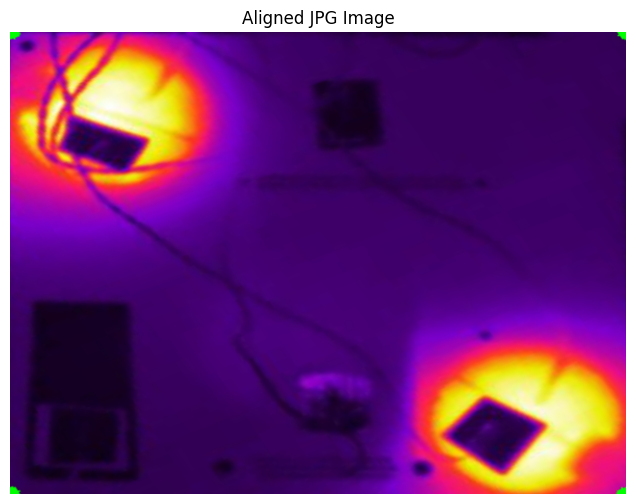

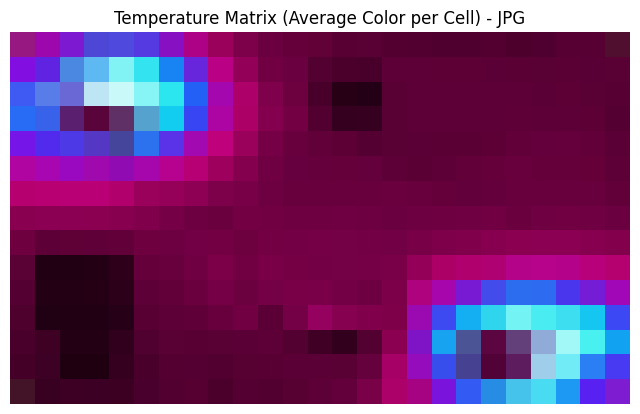

Sample of the RGB matrix from the JPG image:
[[[150.06        24.5125     128.89625   ]
  [156.78846154   8.32091346 172.64302885]
  [124.4475      25.40625    209.6475    ]
  [ 78.89663462  71.109375   214.00240385]
  [ 79.87860577  73.88341346 222.38581731]]

 [[131.95875     14.51625    226.78      ]
  [ 97.59254808  35.97355769 226.27043269]
  [ 74.485      136.84625    226.085     ]
  [ 94.83052885 184.54326923 242.11177885]
  [129.26442308 243.19471154 245.0625    ]]

 [[ 63.7725      89.27125    243.82125   ]
  [ 88.65504808 125.97115385 232.93269231]
  [106.59375    104.3025     213.8575    ]
  [189.02524038 229.93028846 244.03365385]
  [202.42067308 249.90024038 250.17668269]]

 [[ 40.09375    107.84625    245.21375   ]
  [ 57.72956731  98.63942308 235.14423077]
  [ 90.83375     31.74625    110.925     ]
  [ 89.78966346   5.05889423  60.20673077]
  [ 95.78966346  48.51442308 102.34855769]]

 [[117.355       21.3975     231.3275    ]
  [ 82.203125    42.10697115 238.27283654]
 

In [2]:
# Define the full image path
image_path = os.path.join("Images", image_name)

# Check the image extension (.jpg/.png or .tif)
extension = image_name.split('.')[-1].lower()

# Flag to indicate if processing a .tif file
is_tif = False

if extension in ['jpg', 'png']:
    # If the file is .jpg or .png, select corners, align the image, and calculate the RGB temperature matrix
    aligned_image_jpg, temperature_matrix_jpg, corners = select_corners_jpg(cv2.imread(image_path))
    
    # Print a portion of the RGB matrix to ensure it's not grayscale
    print("Sample of the RGB temperature matrix from the JPG image:")
    print(temperature_matrix_jpg[:5, :5, :])  # Print the first 5x5 elements of the RGB matrix

elif extension == 'tif':
    # If the file is .tif, set the flag to skip RGB processing
    is_tif = True

    # Generate a temporary .jpg for corner selection
    temp_png_path = "Images/temp_image.png"
    aligned_visual_tif, aligned_radiometric_data = select_corners_tif(image_path, cv2.imread(image_path, cv2.IMREAD_UNCHANGED), temp_png_path)

    print("TIF image aligned and transformed.")

    # Display the heatmap of the radiometric data with a proper temperature scale
    plt.imshow(aligned_radiometric_data, cmap='hot')
    plt.colorbar(label="Temperature (°C)")
    plt.title("Heatmap of Aligned Radiometric Data (°C)")
    plt.axis('off')
    plt.show()

else:
    # Notify the user if the file format is unsupported
    print("Unsupported file format. Only .jpg, .png, and .tif are supported.")


## Calibrating emissivity


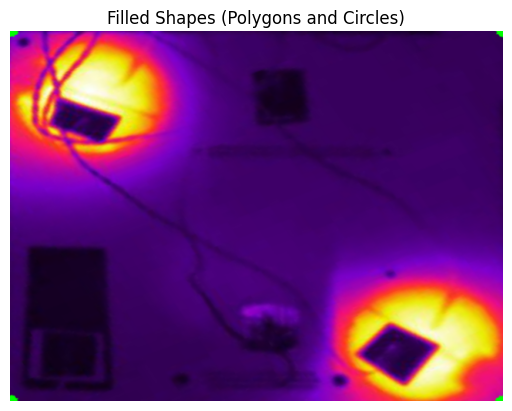

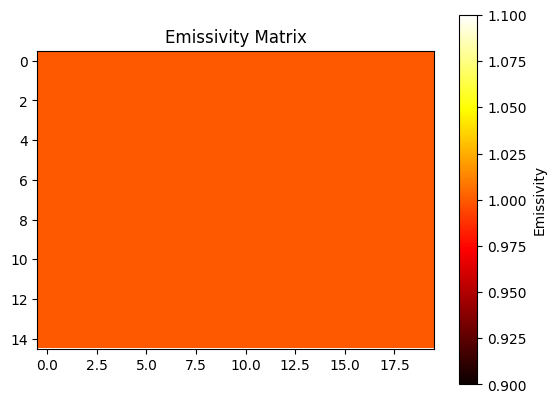


Emissivity information for defined shapes:


In [3]:
# Ask the user for the base emissivity value
base_emissivity = float(input("Enter the base emissivity value for the PCB: "))

# Process emissivity based on the image type
if extension in ['jpg', 'png']:
    emissivity_matrix = ep.process_emissivity(aligned_image_jpg, base_emissivity)
elif extension == 'tif':
    emissivity_matrix = ep.process_emissivity(aligned_visual_tif, base_emissivity)


## Calibrating final temperature heatmap

Click on two points on the PCB where you know the temperature.


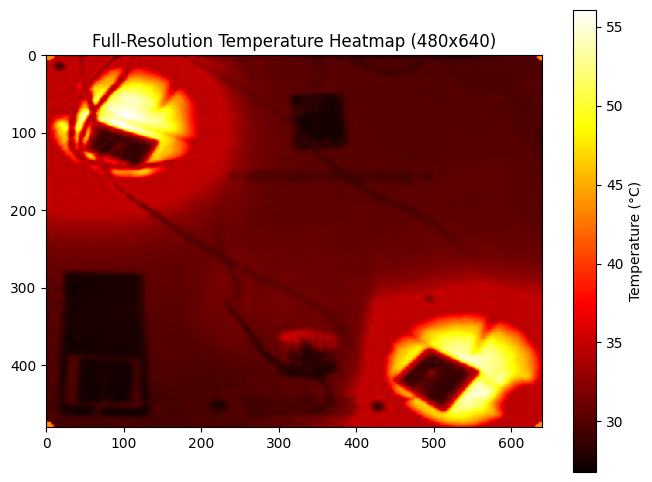

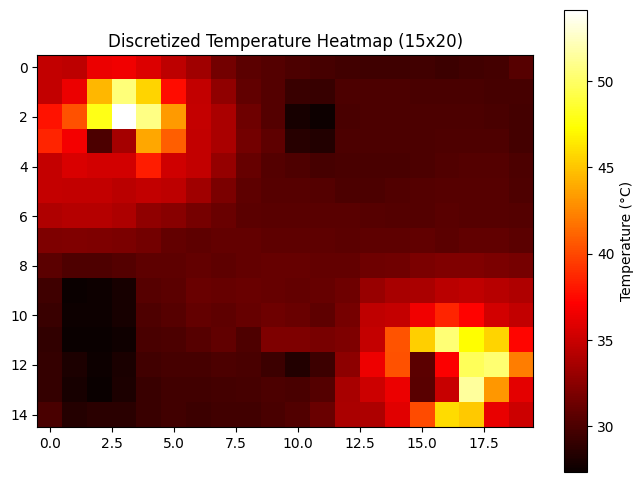

Discretized temperature matrix:
[[34.75225449 34.50288391 36.42845535 36.626091   35.78624725 34.47346497
  33.36774445 31.59470177 30.60698318 30.3049469  29.99232864 29.86281586
  29.63692856 29.50834656 29.45417023 29.5894928  29.438591   29.60948944
  29.75260353 30.47444534]
 [34.7267952  36.38497543 44.46160889 50.53989792 45.58489227 37.64927673
  34.70435715 32.70728683 30.90611267 30.35493851 29.29315567 29.14725113
  30.01255608 30.01034737 30.00011635 29.93710327 29.94814873 29.8799057
  29.83247185 29.85246849]
 [37.84912109 40.3544693  47.9379425  54.12132263 50.82066345 43.26183319
  34.81398773 33.83149719 31.39915657 30.34900856 27.94178009 27.52941322
  29.96256638 30.0002327  30.         30.         30.00592804 29.98511887
  29.9493103  29.74725533]
 [38.57514572 36.76188278 29.97512054 33.60142136 43.87369537 40.85425949
  34.72993469 33.78417969 31.63608932 30.70789528 28.52318192 28.36135292
  29.96837807 30.04859543 29.99790764 30.00244141 30.09323883 30.0837059
 

In [4]:
m, n = 20, 15  # Define the grid size

if extension == 'jpg':
    # Perform temperature calibration for .jpg images (initially using the RGB-based heatmap)
    calibrated_temperature_matrix = cp.calibrate_temperature('jpg', aligned_image_jpg, temperature_matrix_jpg, emissivity_matrix, m, n)
    
    # Visualize the full-scale and discretized heatmap for .jpg
    cp.visualize_temperature_matrix_jpg(calibrated_temperature_matrix)

elif extension == 'tif':
    # Perform temperature calibration for .tif images
    calibrated_temperature_matrix = cp.calibrate_temperature('tif', aligned_radiometric_data, aligned_radiometric_data, emissivity_matrix, m, n)
    
    # Visualize the .tif heatmap
    cp.visualize_temperature_matrix_tif(calibrated_temperature_matrix)


## Conclusion

In this notebook, we successfully loaded and processed thermal images in both .jpg and .tif formats. We applied corner selection, image alignment, emissivity calibration, and temperature matrix visualization. This workflow provides an efficient method to analyze thermographic data with proper calibration and visualization tools.

Next steps include refining the image processing and calibration methods to enhance accuracy and performance for various image types.
